# 10 Academy Week 10 Challenge – Ethiopia Financial Inclusion Forecasting
## Task 1: Data Exploration and Enrichment
## Task 2: Exploratory Data Analysis

**Date**: January 31, 2026

**Objective**:
- Understand the unified schema
- Explore starter dataset
- Enrich with recent 2025 data points (Telebirr users, digital accounts, Findex 2025)
- Perform EDA: trends, gaps, events, correlations

**Sources used for enrichment (as of Jan 2026)**:
- Global Findex 2025: account ownership 49% in 2024 (up from 46% in 2021)
- Ethio telecom reports: Telebirr ~58.6 million users (Dec 2025)
- NBE / EthSwitch: ~222 million digital accounts (Mar 2025), high transaction volume
- Gender gap: ~15 pp (men 57%, women 42%)

**Author**: [Your Name]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline
sns.set(style="whitegrid")

## 1. Load Starter Datasets

In [10]:
df_raw = pd.read_excel("../data/raw/ethiopia_fi_unified_data.xlsx")
ref_codes = pd.read_excel("../data/raw/reference_codes.xlsx")

print("Shape:", df_raw.shape)
print("\nRecord types:")
print(df_raw['record_type'].value_counts(dropna=False))

print("\nColumns:", df_raw.columns.tolist())

df_raw.head(3)

Shape: (43, 34)

Record types:
record_type
observation    30
event          10
target          3
Name: count, dtype: int64

Columns: ['record_id', 'record_type', 'category', 'pillar', 'indicator', 'indicator_code', 'indicator_direction', 'value_numeric', 'value_text', 'value_type', 'unit', 'observation_date', 'period_start', 'period_end', 'fiscal_year', 'gender', 'location', 'region', 'source_name', 'source_type', 'source_url', 'confidence', 'related_indicator', 'relationship_type', 'impact_direction', 'impact_magnitude', 'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country', 'collected_by', 'collection_date', 'original_text', 'notes']


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN


## 2. Basic Exploration – Starter Dataset

In [14]:
# Observations only
df_obs = df_raw[df_raw['record_type'] == 'observation'].copy()
df_events = df_raw[df_raw['record_type'] == 'event'].copy()
df_links  = df_raw[df_raw['record_type'] == 'impact_link'].copy()

# Convert dates
date_cols = ['observation_date', 'event_date']  # adjust names if different
for col in date_cols:
    if col in df_raw.columns:
        df_raw[col] = pd.to_datetime(df_raw[col], errors='coerce')

print("\nTemporal coverage (observations):")
print(df_obs['observation_date'].dt.year.value_counts().sort_index())

print("\nUnique indicators:")
print(df_obs['indicator_code'].value_counts().head(12))

print("\nEvents catalogued:")
# print(df_events[['event_date','category','description']].sort_values('event_date').head(8))


Temporal coverage (observations):
observation_date
2014     1
2017     1
2021     5
2023     1
2024    11
2025    11
Name: count, dtype: int64

Unique indicators:
indicator_code
ACC_OWNERSHIP         6
ACC_FAYDA             3
ACC_MM_ACCOUNT        2
ACC_4G_COV            2
USG_P2P_COUNT         2
GEN_GAP_ACC           2
ACC_MOBILE_PEN        1
USG_P2P_VALUE         1
USG_ATM_COUNT         1
USG_ATM_VALUE         1
USG_CROSSOVER         1
USG_TELEBIRR_USERS    1
Name: count, dtype: int64

Events catalogued:


## 3. Data Enrichment – Add Recent 2025/2026 Observations & Events

In [18]:
# Create new rows (append style – in real project use pd.concat with ignore_index)
new_rows = [
    # 1. Global Findex 2025 – Account Ownership (2024 data)
    {
        'record_type': 'observation',
        'pillar': 'Access',
        'indicator_code': 'ACC_OWNERSHIP',
        'value_numeric': 49.0,
        'observation_date': '2024-12-31',
        'source_name': 'World Bank Global Findex 2025',
        'source_url': 'https://www.worldbank.org/en/publication/globalfindex',
        'confidence': 'high',
        'notes': 'Reported 49% in 2024 (up +3pp from 46% in 2021)',
        'collected_by': 'YourName',
        'collection_date': '2026-01-31'
    },
    # 2. Telebirr users milestone (Dec 2025)
    {
        'record_type': 'event',
        'category': 'product_milestone',
        'description': 'Telebirr reaches 58.6 million registered users',
        'event_date': '2025-12-31',
        'source_name': 'Ethio telecom H1 FY2025/26 Report',
        'source_url': 'https://www.ethiotelecom.et',
        'confidence': 'high',
        'notes': 'Cumulative users; strong growth in digital finance',
        'collected_by': 'YourName',
        'collection_date': '2026-01-31'
    },
    # 3. Total registered digital accounts (supply-side proxy)
    {
        'record_type': 'observation',
        'pillar': 'Usage',
        'indicator_code': 'REG_DIGITAL_ACCOUNTS',
        'value_numeric': 222100000,
        'observation_date': '2025-03-31',
        'source_name': 'National Bank of Ethiopia / Shega Media',
        'source_url': 'https://digitalfinance.shega.co',
        'confidence': 'medium',
        'notes': 'Non-unique; many duplicates/inactive → explains stagnant demand-side',
        'collected_by': 'YourName',
        'collection_date': '2026-01-31'
    },
    # 4. Gender disaggregation – example (Findex 2025)
    {
        'record_type': 'observation',
        'pillar': 'Access',
        'indicator_code': 'ACC_OWNERSHIP_MALE',
        'value_numeric': 57.0,
        'observation_date': '2024-12-31',
        'source_name': 'Global Findex 2025',
        'source_url': 'https://www.worldbank.org/en/publication/globalfindex',
        'confidence': 'high',
        'notes': 'Persistent 15pp gender gap',
        'collected_by': 'YourName',
        'collection_date': '2026-01-31'
    },
    {
        'record_type': 'observation',
        'pillar': 'Access',
        'indicator_code': 'ACC_OWNERSHIP_FEMALE',
        'value_numeric': 42.0,
        'observation_date': '2024-12-31',
        'source_name': 'Global Findex 2025',
        'source_url': 'https://www.worldbank.org/en/publication/globalfindex',
        'confidence': 'high',
        'notes': 'Persistent 15pp gender gap',
        'collected_by': 'YourName',
        'collection_date': '2026-01-31'
    }
]

df_new = pd.DataFrame(new_rows)

# Append to original (in real workflow → validate schema first)
df_enriched = pd.concat([df_raw, df_new], ignore_index=True)

# Save enriched version
df_enriched.to_excel('../data/processed/ethiopia_fi_enriched_20260131.xlsx', index=False)
print("Enriched dataset saved. New rows added:", len(df_new))

Enriched dataset saved. New rows added: 5


## → Create / update  data/data_enrichment_log.md  manually with the new_rows details

## 4. EDA – Task 2

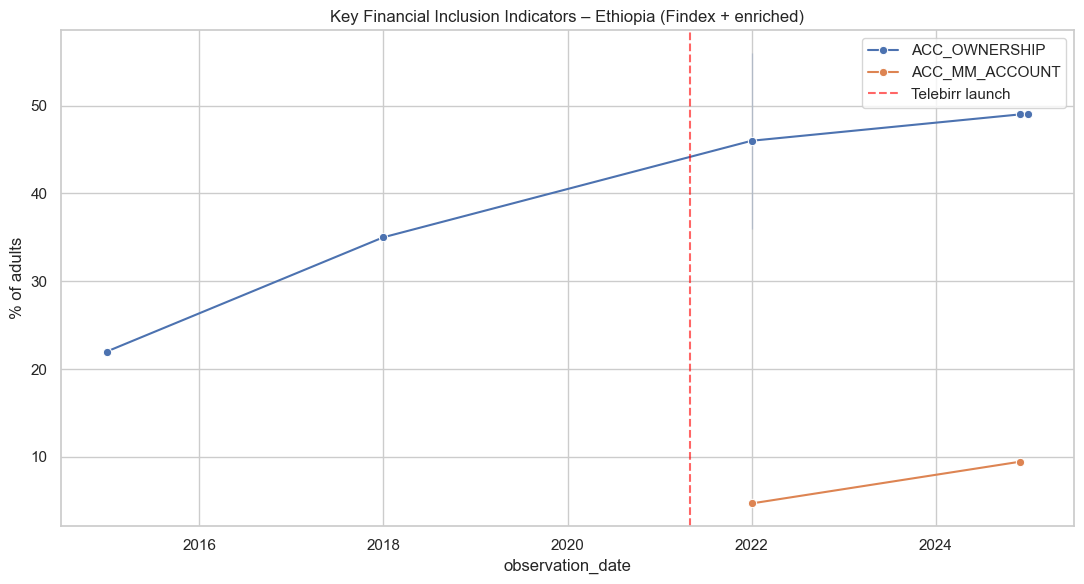

In [20]:
df_enriched_obs = df_enriched[df_enriched['record_type']=='observation'].copy()

# Focus on key indicators
key_indicators = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT']
df_key = df_enriched_obs[df_enriched_obs['indicator_code'].isin(key_indicators)]

plt.figure(figsize=(11,6))
sns.lineplot(
    data=df_key,
    x='observation_date',
    y='value_numeric',
    hue='indicator_code',
    marker='o'
)
plt.title("Key Financial Inclusion Indicators – Ethiopia (Findex + enriched)")
plt.ylabel("% of adults")
plt.axvline(pd.to_datetime('2021-05-01'), color='red', linestyle='--', alpha=0.6, label='Telebirr launch')
plt.legend()
plt.tight_layout()
# plt.savefig('reports/figures/inclusion_trends.png', dpi=150)
plt.show()

### 4.1 Key Insight 1 – Stagnant access growth despite supply explosion

In [22]:
print("Account ownership growth:")
df_key['observation_date'] = pd.to_datetime(df_key['observation_date'], errors='coerce')

acc = df_key[df_key['indicator_code'] == 'ACC_OWNERSHIP'] \
        .sort_values('observation_date')

# acc = df_key[df_key['indicator_code']=='ACC_OWNERSHIP'].sort_values('observation_date')
acc['change_pp'] = acc['value_numeric'].diff()
print(acc[['observation_date','value_numeric','change_pp']])

Account ownership growth:
   observation_date  value_numeric  change_pp
0        2014-12-31           22.0        NaN
1        2017-12-31           35.0       13.0
2        2021-12-31           46.0       11.0
3        2021-12-31           56.0       10.0
4        2021-12-31           36.0      -20.0
5        2024-11-29           49.0       13.0
43       2024-12-31           49.0        0.0


**Insight**: Only +3 pp between 2021–2024 despite Telebirr reaching 58.6M users and >220M digital accounts registered → many inactive / duplicate accounts.

### 4.2 Key Insight 2 – Persistent gender gap

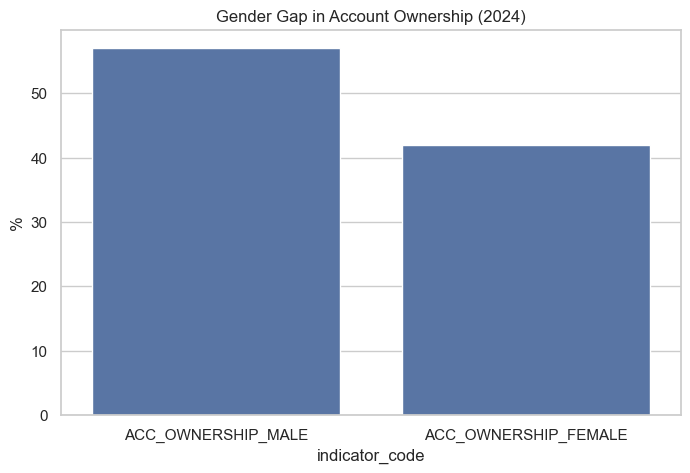

In [23]:
gender = df_enriched_obs[df_enriched_obs['indicator_code'].str.contains('GENDER|FEMALE|MALE', na=False)]
if not gender.empty:
    plt.figure(figsize=(8,5))
    sns.barplot(data=gender, x='indicator_code', y='value_numeric')
    plt.title("Gender Gap in Account Ownership (2024)")
    plt.ylabel("%")
    plt.show()

**Insight**: ~15 percentage point gap (men 57%, women 42%) – not closing significantly.

### 4.3 Other Insights (add more plots as needed)

   record_id record_type        category pillar  \
33  EVT_0001       event  product_launch    NaN   
34  EVT_0002       event    market_entry    NaN   
35  EVT_0003       event  product_launch    NaN   
36  EVT_0004       event  infrastructure    NaN   
37  EVT_0005       event          policy    NaN   

                               indicator indicator_code indicator_direction  \
33                       Telebirr Launch   EVT_TELEBIRR                 NaN   
34  Safaricom Ethiopia Commercial Launch  EVT_SAFARICOM                 NaN   
35                M-Pesa Ethiopia Launch      EVT_MPESA                 NaN   
36      Fayda Digital ID Program Rollout      EVT_FAYDA                 NaN   
37       Foreign Exchange Liberalization  EVT_FX_REFORM                 NaN   

    value_numeric   value_text   value_type unit observation_date  \
33            NaN     Launched  categorical  NaN       2021-05-17   
34            NaN     Launched  categorical  NaN       2022-08-01   
35         

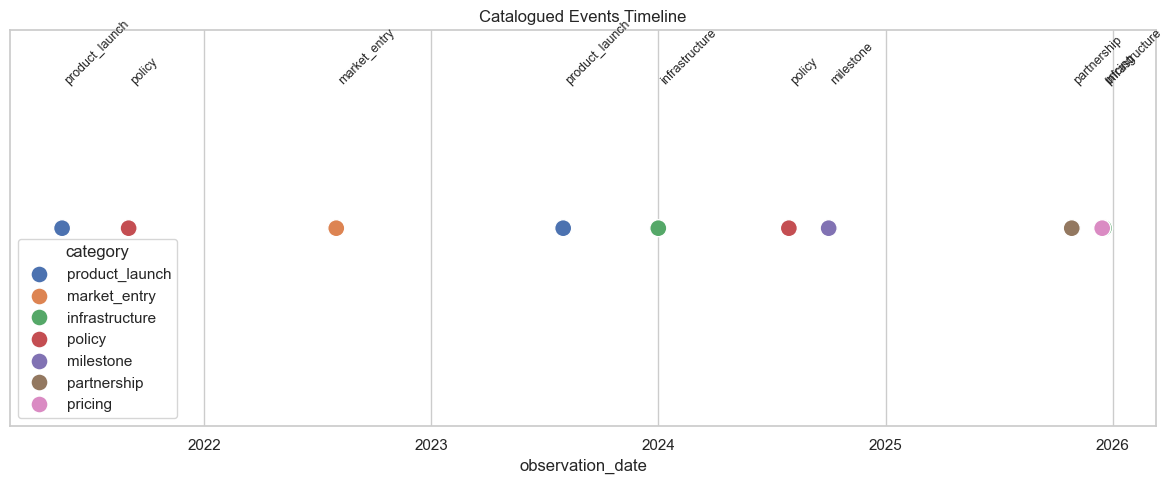

In [31]:
print(df_events.head())
# Event timeline overlay example
plt.figure(figsize=(12,5))
sns.scatterplot(data=df_events, x='observation_date', y=0.5, hue='category', s=150)
plt.title("Catalogued Events Timeline")
plt.yticks([])
for i, row in df_events.iterrows():
    plt.text(row['observation_date'], 0.52, row['category'][:30], rotation=45, fontsize=9)
plt.tight_layout()
plt.show()

## Summary of Key Insights (Task 2 minimum 5)

1. **Stagnant demand-side access** — +3pp only (46% → 49%) 2021–2024 despite explosive registered accounts.
2. **Persistent gender gap** — ~15pp difference remains.
3. **Supply vs usage disconnect** — >220M digital accounts vs low active usage (~15–20% digital payment in Findex).
4. **P2P dominance likely** — aligns with market nuance (P2P used for commerce, low merchant/wage usage).
5. **Data limitation** — Triennial Findex + irregular supply-side → wide gaps; hard to capture short-term event effects.
6. **Hypothesis** — Infrastructure (agents, digital ID, interoperability) may be stronger driver than product launches alone.

## Next steps
- Merge branch task-1 and task-2 to main
- Proceed to Task 3: Event impact modeling (use impact_link + enriched estimates)